<a href="https://colab.research.google.com/github/Pakopac/colab_fastai/blob/master/keras_CatsVSDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# [Ateliers: Technologies des grosses data](https://github.com/wikistat/Ateliers-Big-Data)

# [Reconnaissance d'images](https://github.com/wikistat/Ateliers-Big-Data/tree/master/CatsVSDogs):  [*cats vs. dogs*](https://www.kaggle.com/c/dogs-vs-cats/data)
# Tranfert d'apprentissage avec <a href="https://www.tensorflow.org/"><img src="https://avatars0.githubusercontent.com/u/15658638?s=200&v=4" width=100, style="display: inline" alt="TensorFlow"/></a> tensorflow et  <a href="https://keras.io/"><img src="https://s3.amazonaws.com/keras.io/img/keras-logo-2018-large-1200.png" width=250, style="display: inline" alt="Keras"/></a>

### Résumé
Apprentissage d'un réseau convolutionnel élémentaire puis utilisation de réseaux pré-entrainés (`VGG16`, `InceptionV3`) sur la base [ImageNet](http://www.image-net.org/) afin de résoudre un autre exemple de reconnaissance d'images. Utilisation de [Keras](https://keras.io/) pour piloter la librairie [tensorFlow](https://www.tensorflow.org/). Comparaison des performances des réseaux et des environnements de calcul CPU et GPU.


## Introduction
### Objectifs
La reconnaissance d'images a franchi une étape majeure en 2012. L'empilement de couches de neurones, dont certaines convolutionnelles, ont conduit à des algorithmes nettement plus performants en reconnaissance d'image, traitement du langage naturel, et à l'origine d'un battage médiatique considérable autour de l'apprentissage épais ou *deep learning*. Néanmoins, apprendre un réseau profond comportant des milions de paramètres nécessite une base d'apprentissage excessivement volumineuse (*e.g.* [ImageNet](http://www.image-net.org/)) avec des millions d'images labellisées. 

L'apprentissage s'avère donc très couteux en temps de calcul, même avec des technologies adaptées (GPU). Pour résoudre ce problème il est possible d'utiliser des réseaux *pré-entrainés*. Ces réseaux possèdent une structure particulière, établie de façon heuristique dans différents départements de recherche (Microsoft: Resnet, Google: Inception V3, Facebook: ResNet) avant d'être ajustés sur des banques d'images publiques telles que [ImageNet](http://www.image-net.org/). 

La stratégie de ce  *transfert d'apprentissage* consiste à exploiter la connaissance acquise sur un problème de classification général pour l’appliquer à un problème particulier.

La librairie [Keras](https://keras.io/) permet de construire de tels réseaux en utlisant relativement simplement l'environnement  [tensorFlow](https://www.tensorflow.org/) de Google à partir de programmes récrits en Python. De plus Keras permet d'utiliser les performances d'une carte GPU afin d'atteindre des performances endant possible ce transfert d'apprentissage, même avec des réseaux complexes.

L'objectif de ce tutoriel est de montrer les capacités du *transfert d'apprentissage* permettant de résoudre des problèmes complexes avec des moyens de calcul modestes. Néanmoins, une carte GPU est vivement conseillé.

Ce tutoriel est en grande partie inspiré du [blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) de François Chollet à l'initiative de [Keras](https://keras.io/).

## Environnement matériel et logiciel
Keras et tensorFlow s'installent simplement à partir de la distribution Anaconda de Python. 

In [ ]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np

# Deep Learning Librairies
import tensorflow as tf
import keras.preprocessing.image as kpi
import keras.layers as kl
import keras.optimizers as ko
import keras.backend as k
import keras.models as km
import keras.applications as ka

# Visualisaiton des données
from matplotlib import pyplot as plt

La commande suivante permet de verifier qu'une carte GPU est bien disponible sur la machine utilisée. Si c'est le cas et si Keras a bien été installé dans la configuration GPU (c'est généralement le cas dans l'environement virtuel GPU d'Anaconda), deux options vont apparaitre, une CPU et une GPU. La configuration GPU sera alors automatiquement utilisée.

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10400120283441691572
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18429506847688797911
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [ ]:
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)

GPU


## Prise en charge des données 

### Structure des données 

Les données originales peuvent être téléchargées à partir du site [kaggle](https://www.kaggle.com/c/dogs-vs-cats/data).
L'ensemble d'apprentissage contient 25.000 images. C'est beaucoup trop pour des machines usuelles à moins de se montrer très patient.  Aussi, deux sous-échantillons d'apprentissage ont été créés et disposés dans le dépôt.

1. 100 images de chats et 100 images de chiens plus un échantillon de validation consitué de 40 images de chats et 40 images de chien. 
2. 1000 images de chats et 1000 images de chiens plus un échantillon de validation consitué de 400 images de chats et 400 images de chien.

Pour utiliser certaines fonctionnalités de Keras, les données doivent être organisées selon une abrorescence précise. Les fichiers appartenant à une même classe doivent être dans un même dossier. 

```
data_dir
└───subsample/
│   └───train/
│   │   └───cats/
│   │   │   │   cat.0.jpg
│   │   │   │   cat.1.jpg
│   │   │   │   ...
│   │   └───dogs/
│   │   │   │   dog.0.jpg
│   │   │   │   dog.1.jpg
│   │   │   │   ...
│   └───test/
│   │   └───cats/
│   │   │   │   cat.1000.jpg
│   │   │   │   cat.1000.jpg
│   │   │   │   ...
│   │   └───dogs/
│   │   │   │   dog.1000.jpg
│   │   │   │   dog.1000.jpg
│   │   │   │   ...
```

*N.B.* Des sous-échantillons plus importants créés à partir des données originales doivent être enregistrés en respectant scrupuleusement cette structure.

###  Création d'un jeu d'apprentissage et de validation
Spécifier le chemin du dossier contenant les données, si ce n'est pas le répertoire courant, ainsi que les tailles des échantillons d'apprentissage et de validation.

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/data/' # chemin d'accès aux données

N_train = 200 #2000
N_val = 80 #800

data_dir_sub = data_dir+'subsample_%d_Ntrain_%d_Nval' %(N_train, N_val)

In [23]:
!ls

cats_transformation.png  data  data_dir.zip  drive  sample_data  test


### Illustration des données

La fonction `load_img` permet de charger une image comme une image PIL.

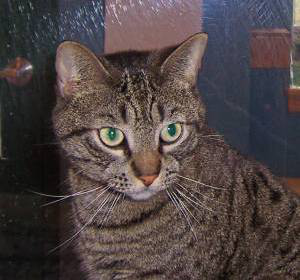

In [27]:
img = kpi.load_img(data_dir_sub+'/train/cats/cat.1.jpg')  # this is a PIL image
img

La fonction `img_to_array` génére un `array numpy` a partir d'une image PIL .

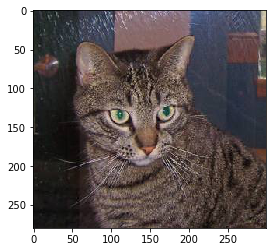

In [28]:
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

### Pré-traitements

Les images du jeu de données sont de dimensions différentes : 

In [29]:
x_0 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/cats/cat.0.jpg"))
x_1 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/cats/cat.1.jpg"))
x_0.shape, x_1.shape

((374, 500, 3), (280, 300, 3))

Or les images doivent être de même dimensions pour être utilisée dans un même réseau.

La fonction `ImageDataGenerator`de `Keras` permet de remédier à ce problème.

Plus généralement cette fonction applique un certain nombre de traitements (transformation, normalisation) aléatoires sur les images de sorte que le modèle n'apprenne jamais deux fois la même image.

Quelques arguments de cette fonction:
* `rotation_range`: Un interval représentant les degrés possibles de rotation de l'image,
* `width_shift` and `height_shift`: intervales au sein desquels les données peuvent être translatées horizontalement ou verticalement, 
* `rescale`:  Une valeur par lequelle les données sont multipliées,
* `shear_range`:  Transvection,
* `zoom_range`: Permet des zoom au sein d'une image,
* `horizontal_flip`: Inverse aléatoirement des images selon l'axe horizontal,
* `fill_mode`: La strategie adoptée pour combler les pixels manquants après une transformation.

In [30]:
datagen = kpi.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

La commande `.flow()` genere de nouveaux exemples à partir de l'image originale et les sauve dans le dossier spécifié dans `save_to_dir`.

On force l'arrêt de cette génération après huits images générées.

In [31]:
img_width = 150
img_height = 150

img = kpi.load_img(data_dir_sub+"/train/cats/cat.1.jpg")  # this is a PIL image
x = kpi.img_to_array(img)  
x_ = x.reshape((1,) + x.shape)

if not(os.path.isdir(data_dir_sub+"/preprocessing_example")):
    os.mkdir(data_dir_sub+"/preprocessing_example")

    i = 0
    for batch in datagen.flow(x_, batch_size=1,save_to_dir=data_dir_sub+"/preprocessing_example", save_prefix='cat', save_format='jpeg'):
        i += 1
        if i > 7:
            break  

Illustration des images transformées.

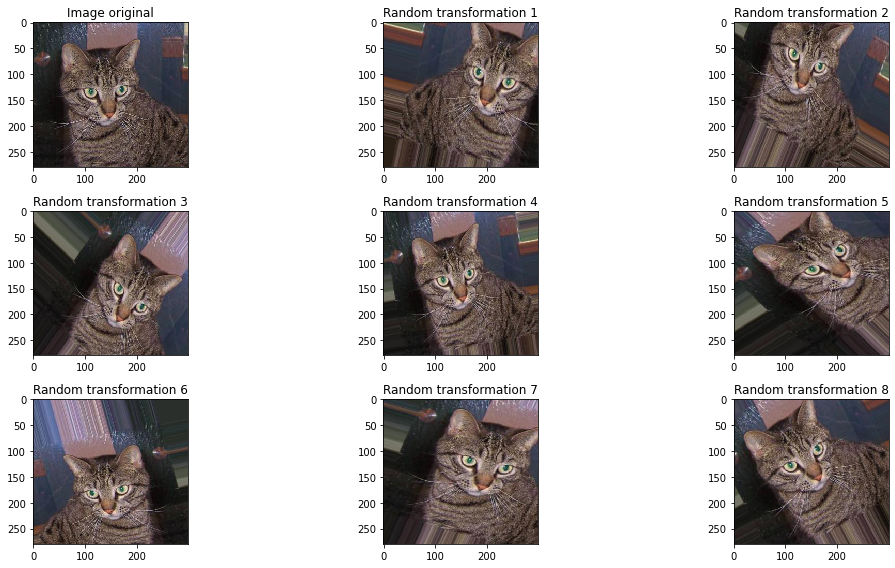

In [32]:
X_list=[]
for f in os.listdir(data_dir_sub+"/preprocessing_example"):
    X_list.append(kpi.img_to_array(kpi.load_img(data_dir_sub+"/preprocessing_example/"+f)))


fig=plt.figure(figsize=(16,8))
fig.patch.set_alpha(0)
ax = fig.add_subplot(3,3,1)
ax.imshow(x/255, interpolation="nearest")
ax.set_title("Image original")
for i,xt in enumerate(X_list):
    ax = fig.add_subplot(3,3,i+2)
    ax.imshow(xt/255, interpolation="nearest")
    ax.set_title("Random transformation %d" %(i+1))
plt.tight_layout()
plt.savefig("cats_transformation.png", dpi=100, bbox_to_anchor="tight", facecolor=fig.get_facecolor())
plt.show()

## Classification d'image à l'aide du Deep Learning

Dans un premier temps, nous allons fixer le nombre d'epochs ainsi que la taille de notre batch afin que ces deux paramètres soit communs aux différentes méthodes que nous allons tester. 
Queques règles à suivre pour le choix de ces paramètres :

* `epochs`: Commencer avec un nombre d'epochs relativement faible (2,3) afin de voir le temps de calcul nécessaire à votre machine, puis augmenter le en conséquence.
* `batch_size`: La taille du batch correspond au nombre d'éléments qui seront étudié a chaque itération au cours d'une epochs. 


**Important** : Avec Keras, lorsque les données sont générés avec un générateur (voir précédemment) la taille du batch doit être un diviseur de la taille de l'échantillon. Sinon l'algorithme aura des comportement anormaux qui ne généreront pas forcément un message d'erreur.


In [ ]:
epochs = 10
batch_size=20

### Réseau convolutionnel

Dans un premiers temps, on construit notre propre réseau de neurones convolutionnel.

#### Génération des données

On définit deux objets `ImageDataGenerator` :

* `train_datagen`: pour l'apprentissage, où différentes transformations sont appliquées, comme précédement
* `valid_datagen`: pour la validation, où l'on applique seulement une transformation *rescale* pour ne pas déformer les données.

Il est également important de définir la taille des images dans laquelle nos images seront reformatées. Ici nous choisirons un taille d'image de 150x150

In [ ]:
# this is the augmentation configuration we will use for training
train_datagen = kpi.ImageDataGenerator(
        rescale=1./255,
)

# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = kpi.ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        data_dir_sub+"/train/",  # this is the target directory
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = valid_datagen.flow_from_directory(
        data_dir_sub+"/validation/",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

#### Définition du modèle

Le modèle est consitué de 3 blocs de convolution consitutés chacun de:

* Une couche de `Convolution2D`
* Une couche d'`Activation` ReLU
* Une couche `MaxPooling2D`

Suivi de :
* Une couche `Flatten`, permettant de convertir les features de 2 à 1 dimensions. 
* Une couche `Dense` (Fully connected layer)
* Une couche d' `Activation` ReLU
* Une couche `Dropout`
* Une couche `Dense` de taille 1 suivi d'une `Activation` sigmoid permettant la classification binaire

On utilise la fonction de perte `binary_crossentropy` pour apprendre notre modèle


In [ ]:
model_conv = km.Sequential()
model_conv.add(kl.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), data_format="channels_last"))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(32, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(64, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_conv.add(kl.Dense(64))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.Dropout(0.5))
model_conv.add(kl.Dense(1))
model_conv.add(kl.Activation('sigmoid'))

model_conv.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


model_conv.summary()

#### Apprentissage

In [ ]:
ts = time.time()
model_conv.fit_generator(train_generator, steps_per_epoch=N_train // batch_size, epochs=epochs,
       validation_data=validation_generator,validation_steps=N_val // batch_size)
te = time.time()
t_learning_conv_simple_model = te-ts
print("Learning TIme for %d epochs : %d seconds"%(epochs,t_learning_conv_simple_model))
model_conv.save(data_dir_sub+'/'+MODE+'_models_convolutional_network_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

#### Prédiction

In [ ]:
ts = time.time()
score_conv_val = model_conv.evaluate_generator(validation_generator, N_val /batch_size, verbose=1)
score_conv_train = model_conv.evaluate_generator(train_generator, N_train / batch_size, verbose=1)
te = time.time()
t_prediction_conv_simple_model = te-ts
print('Train accuracy:', score_conv_train[1])
print('Validation accuracy:', score_conv_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_conv_simple_model )

**Q** Commentez les valeurs de prédictions d'apprentissage et de validation. Comparez les avec les résultats de la dernière epochs d'apprentissage. Qu'observez vous? Est-ce normal?

**Exercice** Re-faites tournez ce modèle en ajoutant plus de transformation aléatoire dans le générateur d'image au moment de l'apprentissage. Que constatez-vous?

### Réseau pré-entrainé : VGG16

Nous allons voir dans cette partie deux façon d'utiliser un modèle pré-entrainé:

1. Dans un premier temps on utilise le modèle pour extraire des features des images qui seront utilisés dans un réseaux de convolution "classique". Ces features sont le résultats des transformations des différents blocs de convolution sur nos images.  
2. Dans un second temps on branchera le modèle "classique" généré  directement sur le modèle pré-entrainé. Ce modèle sera ensuite ré-entraîné plus finement (Fine Tuning) sur le dernier bloc de convolution.


#### Illustration du réseau

![](https://blog.keras.io/img/imgclf/vgg16_original.png)

#### Extraction de nouvelle caractéristiques (*features*)

##### Téléchargement des poids du modèle

Si cest la première fois que vous appeler l'application `VGG16`, le lancement des poids commencera automatiquement et seront stocké dans votre home : `"~/.keras/models"`

On utilise le modèle avec l'option `ìnclude_top` = False. C'est à dire que l'on ne télécharge pas le dernier bloc `Fully connected` classifier. 

La fonction `summary` permet de retrouver la structure décrite précédemment.

In [ ]:
model_VGG16_without_top = ka.VGG16(include_top=False, weights='imagenet')
model_VGG16_without_top.summary()

##### Création des caractéristiques

On applique alors les 5 blocs du modèle VGG16 sur les images de nos échantillons d'apprentissage et de validation.

Cette opération peut-être couteuse, c'est pourquoi on va sauver ces features dans des fichiers afin d'effectuer qu'une fois cette opération.
Si ces fichiers existent, les poids seront téléchargés, sinon il seront créés.

In [ ]:
features_train_path = data_dir_sub+'/features_train.npy' 
features_validation_path = data_dir_sub+'/features_validation.npy' 

if os.path.isfile(features_train_path) and os.path.isfile(features_validation_path):
    print("Load Features")
    features_train = np.load(open(features_train_path, "rb"))
    features_validation = np.load(open(features_validation_path, "rb"))
    
else:
    print("Generate Features")
    datagen = kpi.ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
            data_dir_sub+"/train",
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,  # this means our generator will only yield batches of data, no labels
            shuffle=False)  
    features_train = model_VGG16_without_top.predict_generator(generator, N_train / batch_size,  verbose = 1)
    # save the output as a Numpy array
    np.save(open(features_train_path, 'wb'), features_train)

    
    generator = datagen.flow_from_directory(
        data_dir_sub+"/validation",
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)
    features_validation = model_VGG16_without_top.predict_generator(generator, N_val / batch_size,  verbose = 1)
    # save the output as a Numpy array
    np.save(open(features_validation_path, 'wb'), features_validation)
    

##### Construction d'un réseaux de neurone classique.

On construit un réseaux de neurones "classique", identique à la seconde partie du réseau précédent. 

*Attention* : La première couche de ce réseaux (`Flatten`) doit être configurée pour prendre en compte des données dans la dimension des features générées précédemment

In [ ]:
model_VGG_fcm = km.Sequential()
model_VGG_fcm.add(kl.Flatten(input_shape=features_train.shape[1:]))
model_VGG_fcm.add(kl.Dense(64, activation='relu'))
model_VGG_fcm.add(kl.Dropout(0.5))
model_VGG_fcm.add(kl.Dense(1, activation='sigmoid'))

model_VGG_fcm.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_VGG_fcm.summary()

##### Apprentissage

In [ ]:
# On créer des vecteurs labels

train_labels = np.array([0] * int((N_train/2)) + [1] * int((N_train/2)))
validation_labels = np.array([0] * int((N_val/2)) + [1] * int((N_val/2)))

model_VGG_fcm.fit(features_train, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(features_validation, validation_labels))
t_learning_VGG_fcm = te-ts

**Q** Commentez les performances de ce nouveau modèle

Nous allons également sauver les poids de ce modèle afin de les réusiliser dans la prochaine partie.

In [ ]:
model_VGG_fcm.save_weights(data_dir_sub+'/weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

##### Prédiction

In [ ]:
ts = time.time()
score_VGG_fcm_val = model_VGG_fcm.evaluate(features_validation, validation_labels)
score_VGG_fcm_train = model_VGG_fcm.evaluate(features_train, train_labels)
te = time.time()
t_prediction_VGG_fcm = te-ts
print('Train accuracy:', score_VGG_fcm_train[1])
print('Validation accuracy:', score_VGG_fcm_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_VGG_fcm)

### Ajustement fin du réseau VGG16

Dans la partie précédente, nous avons configurer un bloc de réseaux de neurones, à même de prendre en entrée les features issues des transformation des 5 premiers blocs de convolution du modèle VGG16. 

Dans cette partie, nous allons 'brancher' ce bloc directement sur les cinq premiers blocs du modèle VGG16 pour pouvoir affiner le modèle en itérant a la fois sur les blocs de convolution mais également sur notre bloc de réseau de neurone.

![](https://blog.keras.io/img/imgclf/vgg16_modified.png)

#### Création du modèle

On télécharge dans un premier temps le modèle VGG16, comme précédement. 
Cependant, le modèle va cette fois être "entrainé" directement. Il ne va pas servir qu'a générer des features. Il faut donc préciser en paramètre la taille des images que l'on va lui donner.

In [ ]:
# build the VGG16 network
model_VGG16_without_top = ka.VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))
print('Model loaded.')

On ajoute au modèle VGG, notre bloc de réseaux de neuronne construit précédemment pour générer des features. 
Pour cela, on construit le bloc comme précédemment, puis on y ajoute les poids issus de l'apprentissage réalisé précédemment.

In [ ]:
# build a classifier model to put on top of the convolutional model
top_model = km.Sequential()
top_model.add(kl.Flatten(input_shape=model_VGG16_without_top.output_shape[1:]))
top_model.add(kl.Dense(64, activation='relu'))
top_model.add(kl.Dropout(0.5))
top_model.add(kl.Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning

top_model.load_weights(data_dir_sub+'/weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))


Enfin on assemble les deux parties du modèles

In [ ]:
# add the model on top of the convolutional base
model_VGG_LastConv_fcm = km.Model(inputs=model_VGG16_without_top.input, outputs=top_model(model_VGG16_without_top.output))

model_VGG_LastConv_fcm.summary()

#### Gèle des 4 premiers blocs de convolution

En pratique, et pour pouvoir effectuer ces calculs dans un temps raisonable, nous allons "fine-tuner" seulement le dernier bloc de convolution du modèle, le bloc 5 (couches 16 à 19 dans le summary du modèle précédent) ainsi que le bloc de réseau de neurones que nous avons ajoutés. 

Pour cela on va "geler" (Freeze) les 15 premières couches du modèle pour que leur paramètre ne soit pas optimiser pendant la phase d'apprentissage.

In [ ]:
for layer in model_VGG_LastConv_fcm.layers[:15]:
    layer.trainable = False

#### Generate Data

In [ ]:
# prepare data augmentation configuration
train_datagen = kpi.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = kpi.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    data_dir_sub+"/train/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    data_dir_sub+"/validation/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')


#### Apprentissage

In [ ]:
model_VGG_LastConv_fcm.compile(loss='binary_crossentropy',
              optimizer=ko.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])


# fine-tune the model
ts = time.time()
model_VGG_LastConv_fcm.fit_generator(
    train_generator,
    steps_per_epoch=N_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=N_val // batch_size)
te = time.time()
t_learning_VGG_LastConv_fcm = te-ts


####  Prédiction

In [ ]:
ts = time.time()
score_VGG_LastConv_fcm_val = model_VGG_LastConv_fcm.evaluate_generator(validation_generator, N_val // batch_size)
score_VGG_LastConv_fcm_train = model_VGG_LastConv_fcm.evaluate_generator(train_generator, N_train // batch_size)

te = time.time()
t_prediction_VGG_LastConv_fcm = te-ts
print('Train accuracy:', score_VGG_LastConv_fcm_val[1])
print('Validation accuracy:', score_VGG_LastConv_fcm_train[1])
print("Time Prediction: %.2f seconds" %t_prediction_VGG_LastConv_fcm)

###  Autres modèles

Keras possède un certain nombre d'autres modèles pré-entrainés:

* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet

Certains possèdent une structure bien plus complexe, notamment `InceptionV3`. Vous pouvez très facilement remplacer la fonction `ka.VGG16` par une autre fonction (ex : `ka.InceptionV3`) pour tester la performance des ces différents modèles et leur complexité.

**Exercice** Vous pouvez re-effectuer les manipulations précédentes sur d'autres modèle pré-entrainé, en prenant le temps d'étudiez leur architecture.

**Exercice** Vous pouvez également re-effectuer ces apprentissage sur un jeu de données plus gros en en créant un nouveau à partir des données originales. 

L'application de ces exercices sur les données du challenge est vivement conseillées :)


### Prédiction sur le jeu test de Kaggle

Voyons à présent comment notre réseau performe sur un échantillon du dataset test de keras.

In [ ]:
data_dir_test = data_dir+'test/'
N_test = len(os.listdir(data_dir_test+"/test"))

test_datagen = kpi.ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    data_dir_test,
    #data_dir_sub+"/train/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

test_prediction = model_VGG_LastConv_fcm.predict_generator(test_generator, N_test // batch_size)

In [ ]:
images_test = [data_dir_test+"/test/"+k for k in os.listdir(data_dir_test+"/test")][:9]
x_test  = [kpi.img_to_array(kpi.load_img(image_test))/255 for image_test in images_test]  # this is a PIL image

fig = plt.figure(figsize=(10,10))
for k in range(9):
    ax = fig.add_subplot(3,3,k+1)
    ax.imshow(x_test[k], interpolation='nearest')
    pred = test_prediction[k]
    if pred >0.5:
        title = "Probabiliy for dog : %.1f" %(pred*100)
    else:
        title = "Probabiliy for cat : %.1f" %((1-pred)*100)
    ax.set_title(title)
plt.show()